In [2]:
import scanpy as sc

from scprint import scPrint
from scprint.tasks import Embedder, Denoiser, GNInfer

from scdataloader import Preprocessor
from scdataloader.utils import load_genes

import numpy as np
import pandas as pd
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

from collections import Counter
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr

from scdataloader import DataModule
from scprint.tasks import GNInfer
from anndata.utils import make_index_unique
from bengrn import BenGRN

import json

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from huggingface_hub import hf_hub_download

model_checkpoint_file = hf_hub_download(
    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
)

In [4]:
m = torch.load(model_checkpoint_file, map_location=torch.device("cpu"))
if "label_counts" in m["hyper_parameters"]:
    model = scPrint.load_from_checkpoint(
        model_checkpoint_file,
        precpt_gene_emb=None,
        classes=m["hyper_parameters"]["label_counts"],
    )
else:
    model = scPrint.load_from_checkpoint(
        model_checkpoint_file,
        precpt_gene_emb=None,
    )
del m

FYI: scPrint is not attached to a `Trainer`.


In [2]:
m = torch.load('../../xzp23r4p.ckpt', map_location=torch.device('cpu'))

In [3]:
model = scPrint.load_from_checkpoint(
    '../../xzp23r4p.ckpt', precpt_gene_emb=None, classes=m['hyper_parameters']['label_counts'], 
)#strict=False)
    #transformer="normal")
del m

FYI: scPrint is not attached to a `Trainer`.


## Loading the data

In [ ]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


In [5]:
adata = sc.read(
    "data/human_brain_smartv4.h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/f156b755-78c7-4928-917a-be138c153b85.h5ad",
)


  0%|          | 0.00/2.47G [00:00<?, ?B/s]

In [8]:
adata.X.sum()

66897050000.0

In [ ]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())

Dropping layers:  KeysView(Layers with keys: exon, intron)
checking raw counts
removed 0 non primary cells, 49417 renamining
filtered out 0 cells, 49417 renamining
Removed 0 genes.
startin QC
Seeing 10181 outliers (20.60% of total dataset):
done
AnnData object with n_obs × n_vars = 49417 × 70704
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'develo

AnnData object with n_obs × n_vars = 49417 × 35793
    obs: 'suspension_type', 'cluster', 'class', 'subclass', 'sex_ontology_term_id', 'region', 'cortical_layer', 'cell_type_accession', 'cell_type_alias', 'cell_type_alt_alias', 'cell_type_designation', 'donor_id', 'outlier_call', 'outlier_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'cell_type_ontology_term_id', 'Specimen ID', 'sample_tissue_type', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cause_of_death', 'PMI (hr)', 'Tissue (RIN)', 'Hemisphere Sampled', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'cortical_layer_colors', 'region_colors', 'schema_reference', 'schema

# testing

In [5]:
from bengrn.GeneRNIB_reg2 import run_gene_rnib, download_bench, NORMAN, OP, ADAMSON

In [5]:
download_bench()

Downloading...
From (original): https://drive.google.com/uc?id=1P2U1T0Z6sU4W2WuvK0FIHB2nXA-3YdVT
From (redirected): https://drive.google.com/uc?id=1P2U1T0Z6sU4W2WuvK0FIHB2nXA-3YdVT&confirm=t&uuid=04a1122e-d1ba-4635-80c8-5484c3b37baa
To: /home/ml4ig1/Documents code/benGRN/data/output.tar.gz
100%|██████████| 86.1M/86.1M [00:00<00:00, 107MB/s] 


Extracted output.tar.gz to /home/ml4ig1/Documents code/benGRN/bengrn/../data/output.tar.gz


In [60]:
adata = sc.read_h5ad(ADAMSON)
adata.obs['organism_ontology_term_id'] = 'NCBITaxon:9606'

In [8]:
adata.X[0].sum()

479.27356

In [61]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, drop_non_primary=False,
                            do_postp=False, min_valid_genes_id=1000, min_dataset_size=64, is_symbol=True, use_raw=False)
adata = preprocessor(adata.copy())

Dropping layers:  KeysView(Layers with keys: X_norm)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 1472 renamining
filtered out 0 cells, 1472 renamining
Removed 1252 genes not known to the ontology
Removed 0 duplicate genes
Added 67024 genes in the ontology but not present in the dataset
starting QC
Seeing 8 outliers (0.54% of total dataset):
done
AnnData object with n_obs × n_vars = 1472 × 70704
    obs: 'perturbation', 'is_control', 'perturbation_type', 'n_genes', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'n_features_theta_0.0', 'n_features_theta_0.5', '

In [2]:
adata = sc.read(
    "data/lung_smart2.h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",
)

In [4]:
adata = sc.read(
    "data/glio_smart.h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

In [5]:
adata = sc.read(
    "data/bone_marrow_5batch.h5ad",
    backup_url='https://datasets.cellxgene.cziscience.com/b2eca8f3-b461-45fd-8639-890bbbf050aa.h5ad'
)

In [6]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, drop_non_primary=False,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
adata = preprocessor(adata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 66613 renamining
filtered out 4 cells, 66609 renamining
Removed 8 genes not known to the ontology
Removed 0 duplicate genes
Added 20884 genes in the ontology but not present in the dataset
starting QC
Seeing 28427 outliers (42.68% of total dataset):
done
AnnData object with n_obs × n_vars = 66609 × 70704
    obs: 'Dataset', 'donor_id', 'suspension_type', 'Original_annotation', 'CellHint_harmonised_group', 'Curated_annotation', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_type', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_coun

In [41]:
adata.layers['true'] = adata.X.copy()

In [42]:
adata.X.sum(1).mean(), adata.shape

390666.25

In [ ]:
1_039_835: 0.85 - 0.56 <- 10_000
390_666: 0.73 - 0.42 <- 4_000


In [43]:
# denoising without
denoise = Denoiser(
    batch_size=10,
    max_len=10_000,
    max_cells=2_000,
    doplot=False,
    num_workers=4,
    predict_depth_mult=5,
    how="most var",
    downsample_expr=0.8,
)
metrics, idx, nadata = denoise(model, adata)
metrics

working on 8922 accepted genes


/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 200/200 [00:46<00:00,  4.28it/s]


AnnData object with n_obs × n_vars = 2000 × 44756
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


{'reco2noisy': 0.2449068152884313,
 'reco2full': 0.7351784139319567,
 'noisy2full': 0.3578098361195504}

In [45]:
nadata = adata[:, adata.var.index.isin(model.genes)]

sc.pp.highly_variable_genes(
    nadata, flavor="seurat_v3", n_top_genes=10_000, span=0.99)

subadata = nadata[:, nadata.var.highly_variable].copy()
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.8)

In [47]:
denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

Calculating MAGIC...
  Running MAGIC on 3567 cells and 10000 genes.
  Running MAGIC on 3567 cells and 10000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.67 seconds.
    Calculating affinities...
    Calculated affinities in 0.71 seconds.
  Calculated graph and diffusion operator in 4.39 seconds.
  Calculating imputation...
  Calculated imputation in 0.04 seconds.
Calculated MAGIC in 5.27 seconds.


In [48]:
reco = denoised_adata.X
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.17452298137061376,
 'reco2full': 0.4422112299809244,
 'noisy2full': 0.35767520456666974}

In [ ]:
# embedding and cell type prediction

In [7]:
embed = Embedder(how="random expr", max_len=4000, num_workers=12, pred_embedding = ["cell_type_ontology_term_id"], batch_size=60)

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 1111/1111 [07:13<00:00,  2.57it/s]


AnnData object with n_obs × n_vars = 66609 × 44756
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:171: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="sprint_leiden")


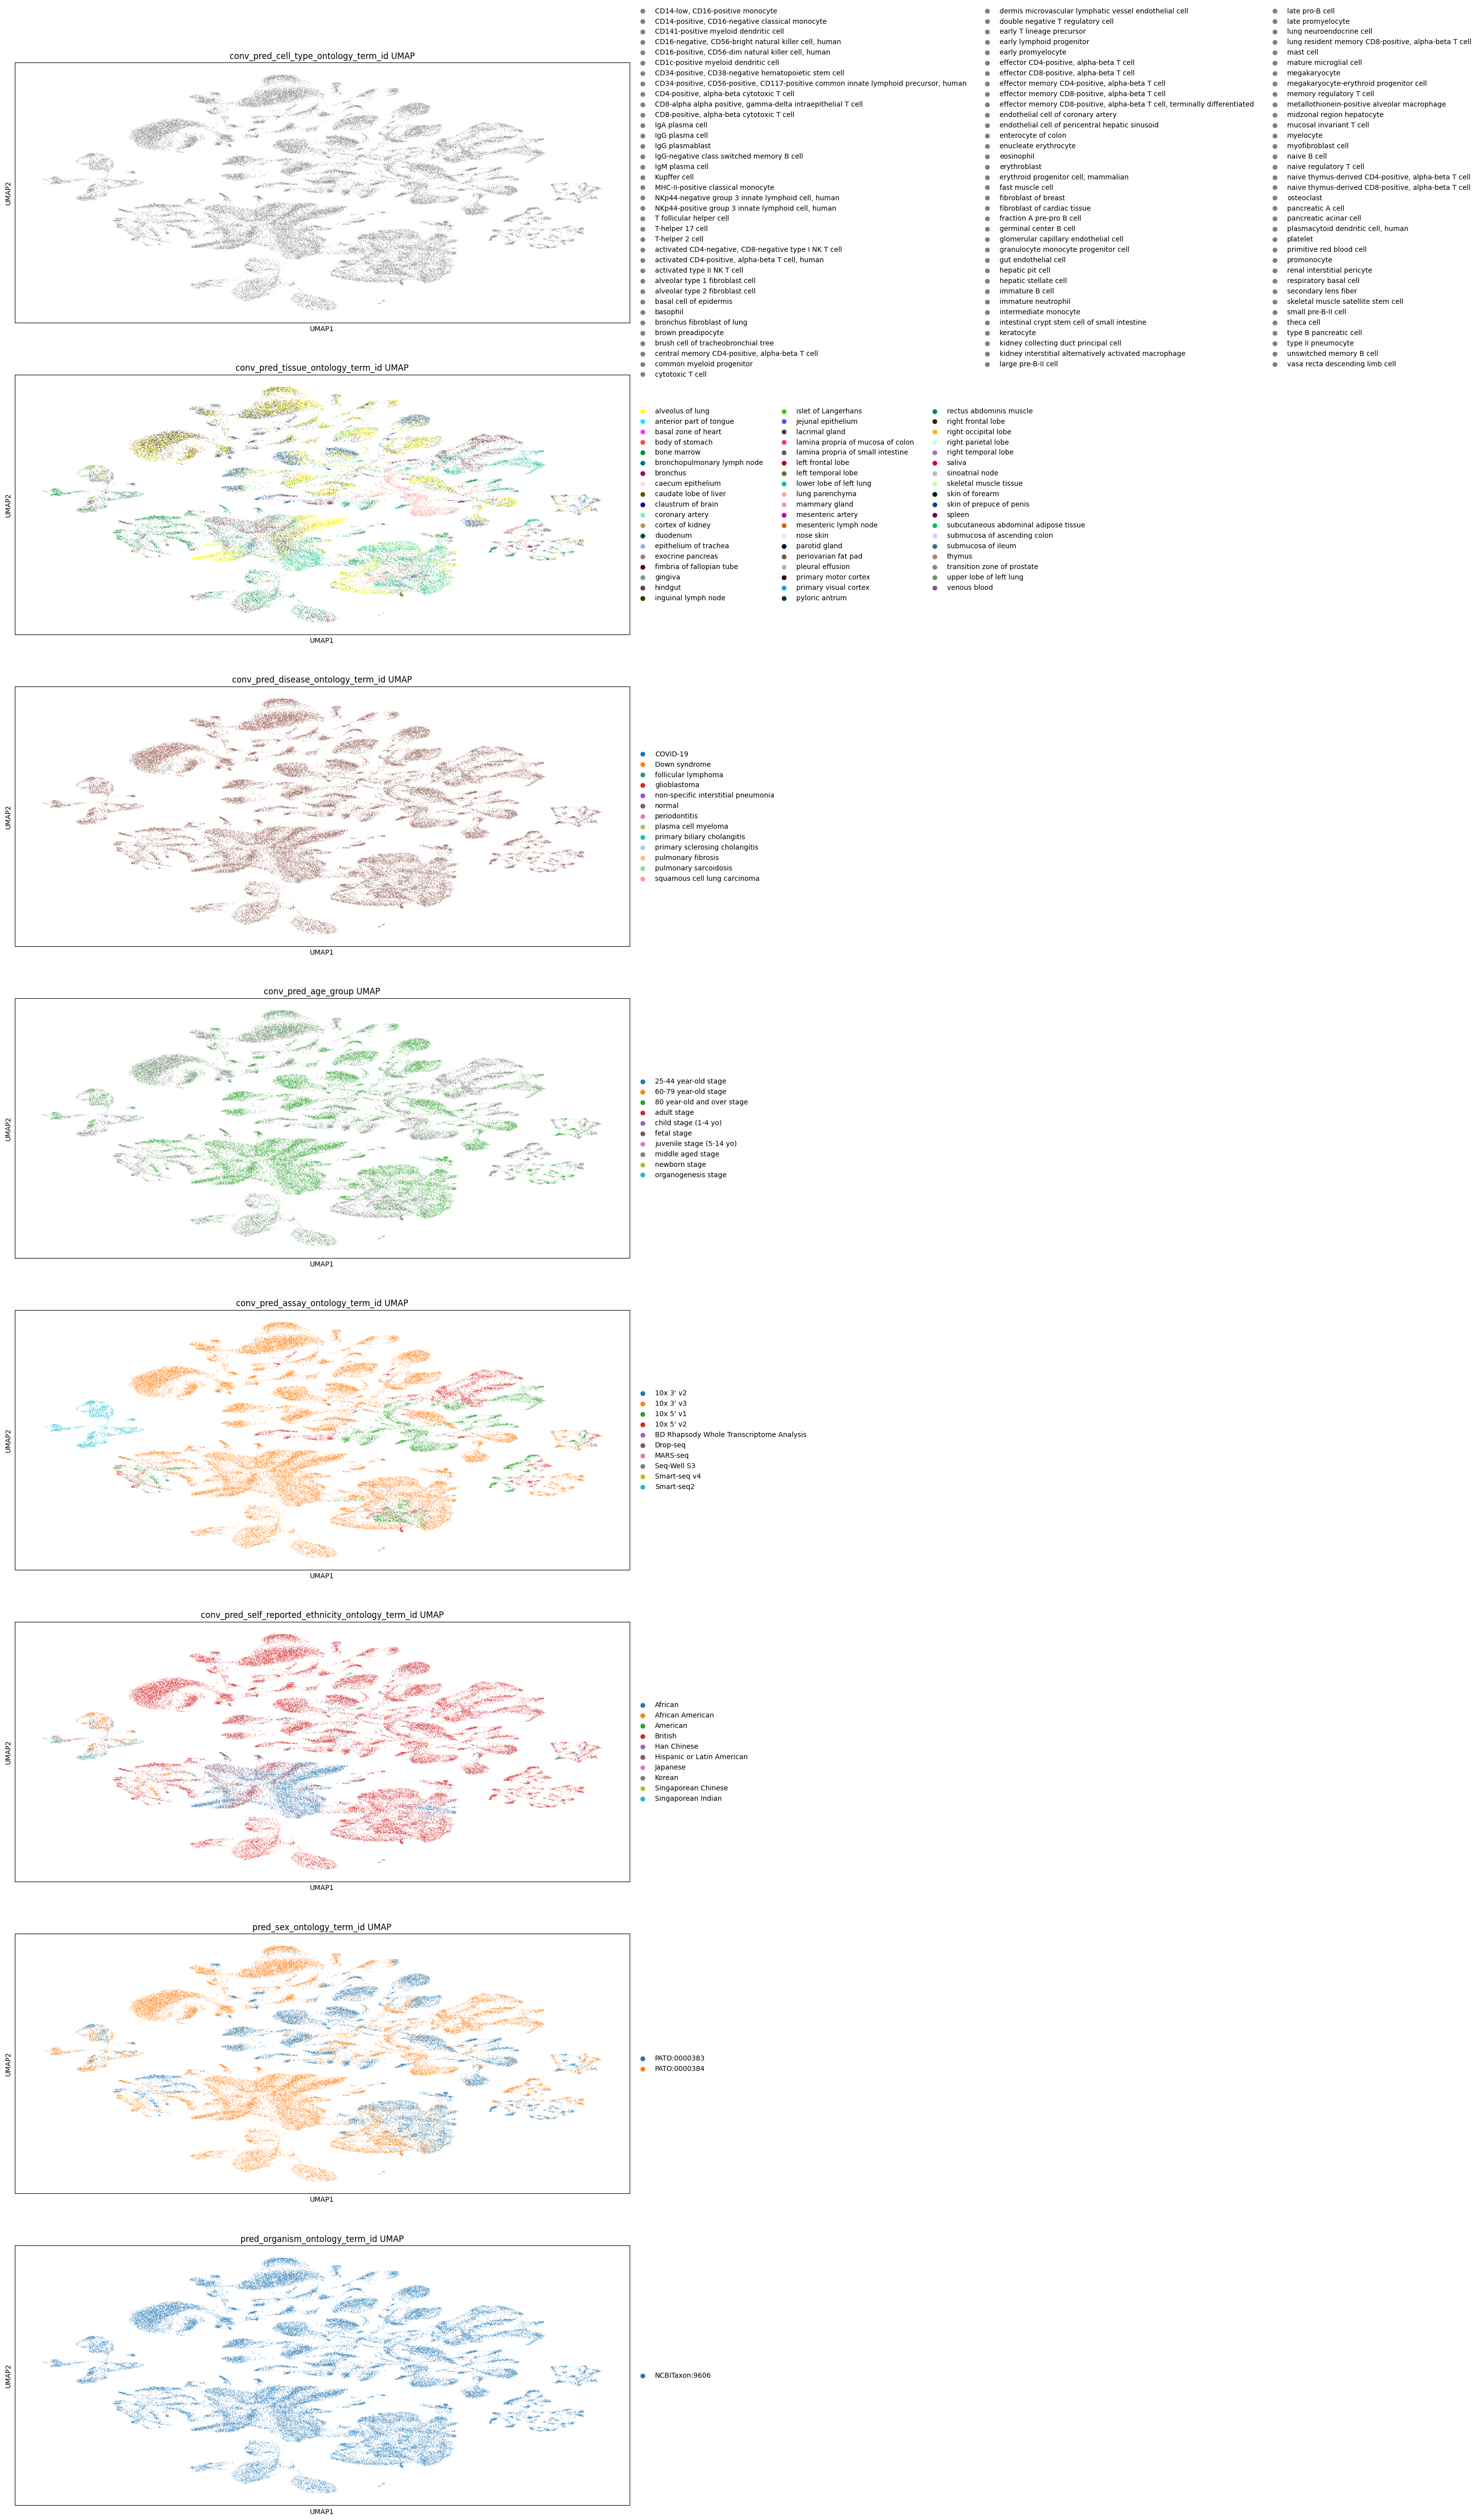

couldn't log to tensorboard
couldn't log to wandb
too few cells to compute a clustering
     cell_type_ontology_term_id
     accuracy: 0.5175126484409014
 
     tissue_ontology_term_id
     accuracy: 0.15694575808073985
 
     disease_ontology_term_id
     accuracy: 0.9788767283700401
 
     assay_ontology_term_id
     accuracy: 0.9802579231034845
 
     self_reported_ethnicity_ontology_term_id
     accuracy: 0.7423030303030304
 
     sex_ontology_term_id
     accuracy: 0.8651833836268372
 
     organism_ontology_term_id
     accuracy: 1.0
 


In [8]:
n_adata, metrics = embed(model, adata.copy(), cache=False)

In [84]:
n_adata

AnnData object with n_obs × n_vars = 11201 × 70704
    obs: 'Dataset', 'donor_id', 'suspension_type', 'Original_annotation', 'CellHint_harmonised_group', 'Curated_annotation', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_type', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id

... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


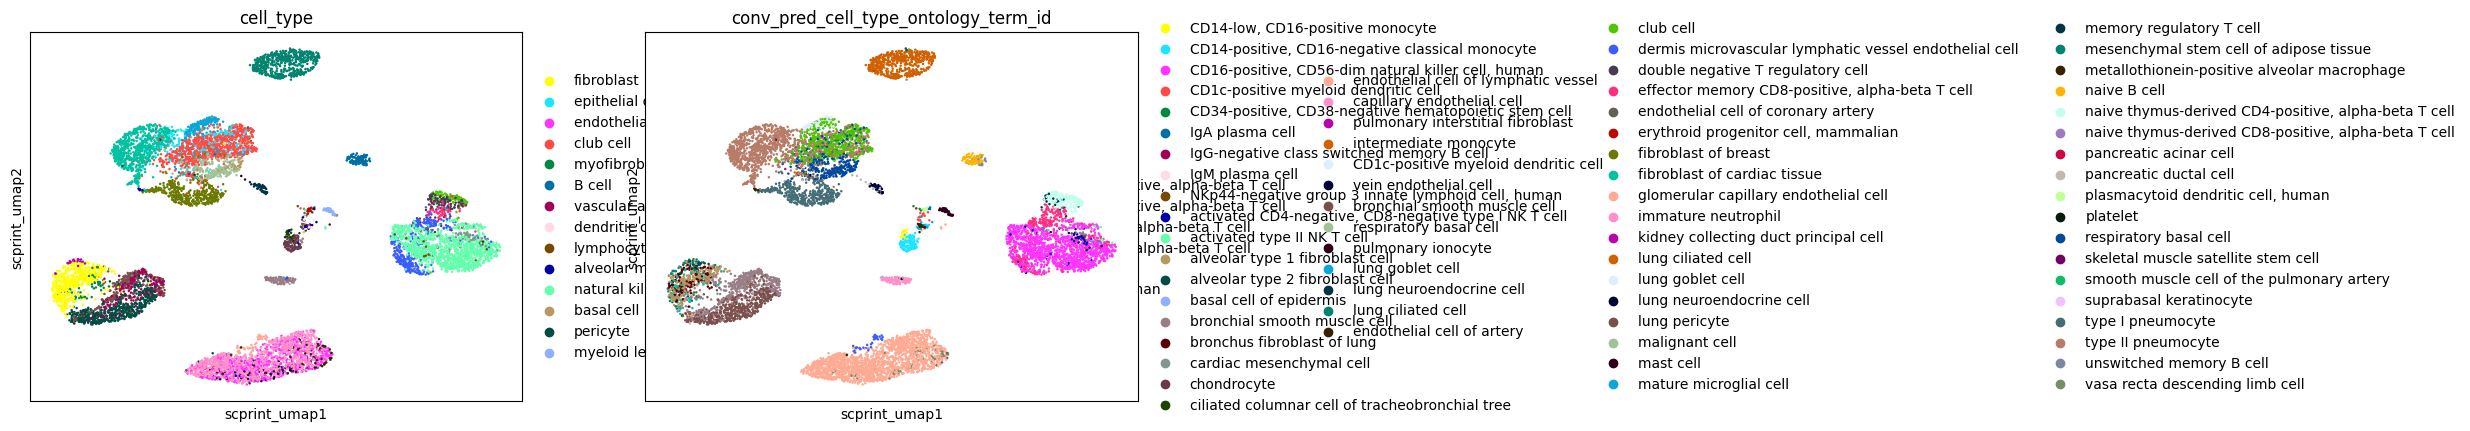

In [68]:
sc.pl.embedding(n_adata, basis="scprint_umap",color=["cell_type", "conv_pred_cell_type_ontology_term_id"])

In [76]:
adata.obs['assay_ontology_term_id']

index
A1_B002014.gencode.vH29     EFO:0008931
A1_B003138.gencode.vH29     EFO:0008931
A1_B003140.gencode.vH29     EFO:0008931
A10_B003138.gencode.vH29    EFO:0008931
A12_B003141.gencode.vH29    EFO:0008931
                               ...     
M5_B001771.gencode.vH29     EFO:0008931
N2_B001769.gencode.vH29     EFO:0008931
N2_B002460.gencode.vH29     EFO:0008931
O2_B001774.gencode.vH29     EFO:0008931
O7_B001774.gencode.vH29     EFO:0008931
Name: assay_ontology_term_id, Length: 9409, dtype: category
Categories (1, object): ['EFO:0008931']

In [9]:
bm = Benchmarker(
    n_adata,
    batch_key="assay_ontology_term_id", #batch, tech
    label_key="cell_type_ontology_term_id", #celltype
    embedding_obsm_keys=["scprint_emb"],
    bio_conservation_metrics=BioConservation(isolated_labels=False),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=20,
)
bm.benchmark()

/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]INFO:2025-04-15 14:11:35,178:jax._src.xla_bridge:925: Unable to initialize backend 'cuda': 
[d3graph] INFO> Unable to initialize backend 'cuda': 
INFO:2025-04-15 14:11:35,181:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[d3graph] INFO> Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-15 14:11:35,232:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared o

INFO     CL:0001058 consists of a single batch or is too small. Skip.                                              


Metrics:  60%|██████    | 6/10 [25:21<09:56, 149.21s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 1/1 [25:24<00:00, 1524.55s/it]


In [10]:
bm.get_results(min_max_scale=False)

KMeans NMI        KMeans ARI  Silhouette label  \
Embedding                                                           
scprint_emb          0.583405          0.294107          0.517006   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

                        cLISI  Silhouette batch             iLISI  \
Embedding                                                           
scprint_emb          0.996011          0.806162               0.0   
Metric Type  Bio conservation  Batch correction  Batch correction   

                         KBET Graph connectivity    PCR comparison  \
Embedding                                                            
scprint_emb          0.327459           0.636251                 0   
Metric Type  Batch correction   Batch correction  Batch correction   

            Batch correction Bio conservation            Total  
Embedding                                                       
scprint_emb         0.353974         0.597632         0.500169  
Metric Type  Aggregate score  Aggregate score  Aggregate score

# gene networks

In [62]:
adata.obs['cell_type'] = "all"

number of expressed genes in this cell type: 3211


/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 148/148 [00:11<00:00, 13.24it/s]
... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


avg link count: 10719076, sparsity: 1.0
base enrichment
Top central genes: []


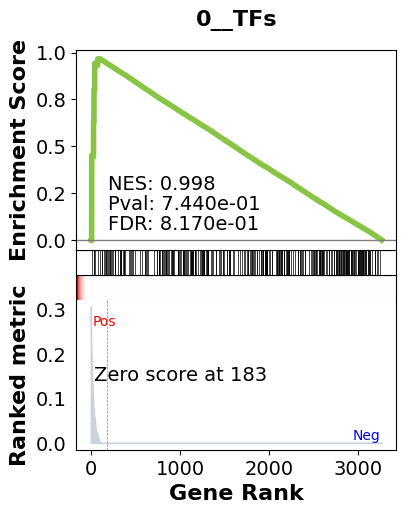

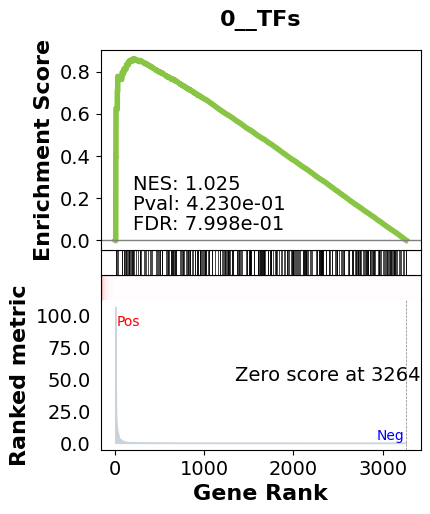

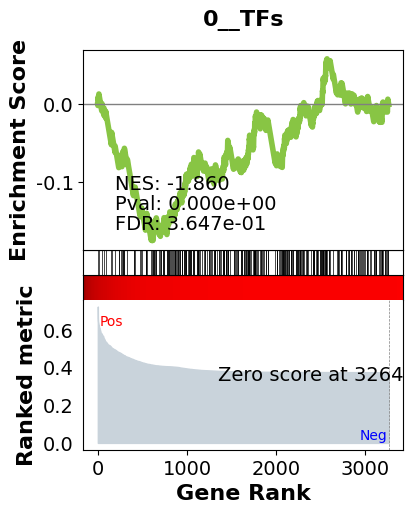

_________________________________________
TF specific enrichment
found some significant results for  16.666666666666668 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1569 genes
intersection pct: 0.4805513016845329
only tf:  False
using only tf:  0.4805513016845329
total true edges:  10591.0
precision:  0.0043022048037969565 
recall:  1.0 
random precision: 0.004304948556860603


 80%|████████  | 103/128 [00:00<00:00, 253.34it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:924: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 253.12it/s]


Average Precision (AP):  0.005293993213332391
Area Under Precision-Recall Curve (AUPRC):  0.005284012767389459
EPR: 1.8558819991646698


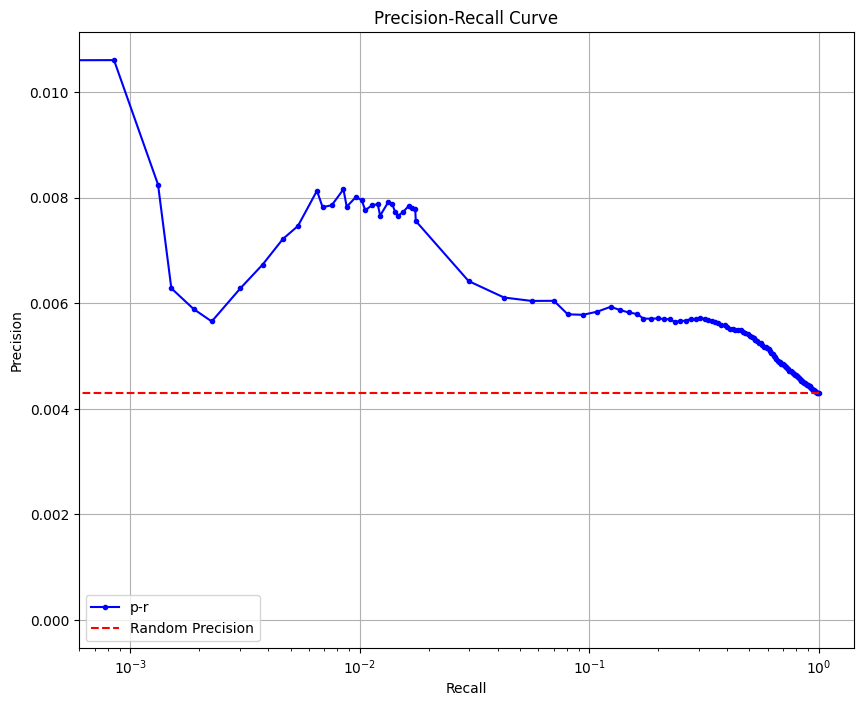

{'all_scprint_full': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Basophils'],
  'significant_enriched_TFtargets': 16.666666666666668,
  'precision': 0.0043022048037969565,
  'recall': 1.0,
  'rand_precision': 0.004304948556860603,
  'auprc': 0.005284012767389459,
  'ap': 0.005293993213332391,
  'epr': 1.8558819991646698}}

In [63]:
# gene network inference without
metrics = {}
clf_omni = None
shapes = []
for celltype in ['all']: #['oligodendrocyte precursor cell']:
    grn_inferer = GNInfer(
                        how="most var within",
                        preprocess="softmax",
                        head_agg='mean',
                        filtration="none",
                        forward_mode="none",
                        num_genes=4_000,
                        max_cells=5000,
                        doplot=False,
                        batch_size=10,
                        cell_type_col="cell_type",
                        layer=list(range(model.nlayers))[:]
                        )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    metrics[celltype+'_scprint_full'] = BenGRN(grn).scprint_benchmark()
    #grn.write_h5ad(f'../data/temp/grn_{celltype}_scprint_f.h5ad')
metrics

In [9]:
adata.obs['cell_type'].value_counts()

cell_type
CD16-positive, CD56-dim natural killer cell, human                            8779
central memory CD4-positive, alpha-beta T cell                                7978
classical monocyte                                                            7615
effector memory CD8-positive, alpha-beta T cell, terminally differentiated    7013
effector memory CD8-positive, alpha-beta T cell                               4771
hematopoietic multipotent progenitor cell                                     4448
neutrophil                                                                    3110
erythroid lineage cell                                                        2860
neutrophil progenitor cell                                                    2022
pro-B cell                                                                    1751
effector memory CD4-positive, alpha-beta T cell                               1604
gamma-delta T cell                                                           

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:372: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)
100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


avg link count: 9054081, sparsity: 1.0
base enrichment
Top central genes: []


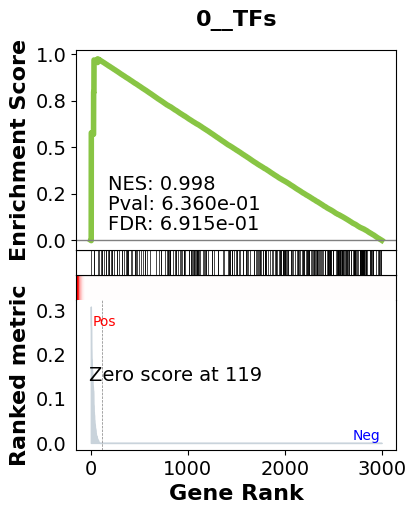

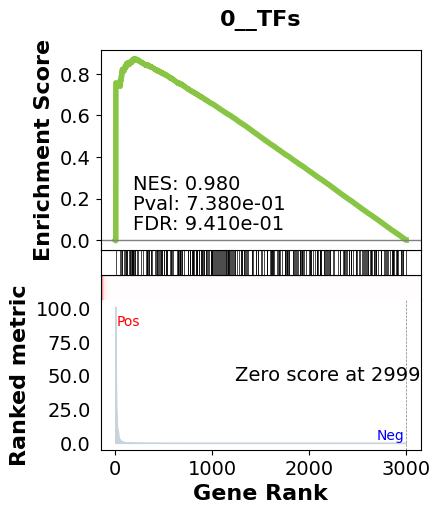

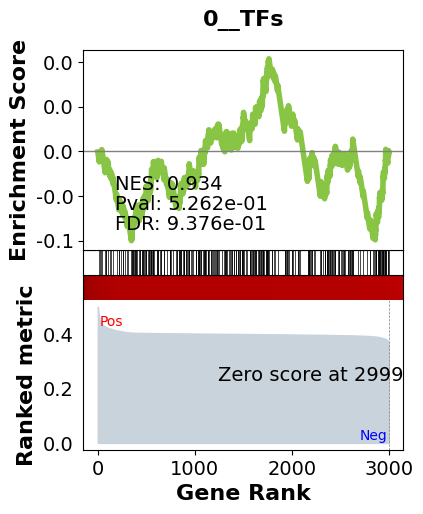

_________________________________________
TF specific enrichment
found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1084 genes
intersection pct: 0.36133333333333334
precision:  0.0034602606173663214 
recall:  1.0 
random precision: 0.003463455687188451


 77%|███████▋  | 98/128 [00:00<00:00, 490.15it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:920: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 487.90it/s]


Average Precision (AP):  0.003783484593053828
Area Under Precision-Recall Curve (AUPRC):  0.0037769645332199407
EPR: 2.00204937688296


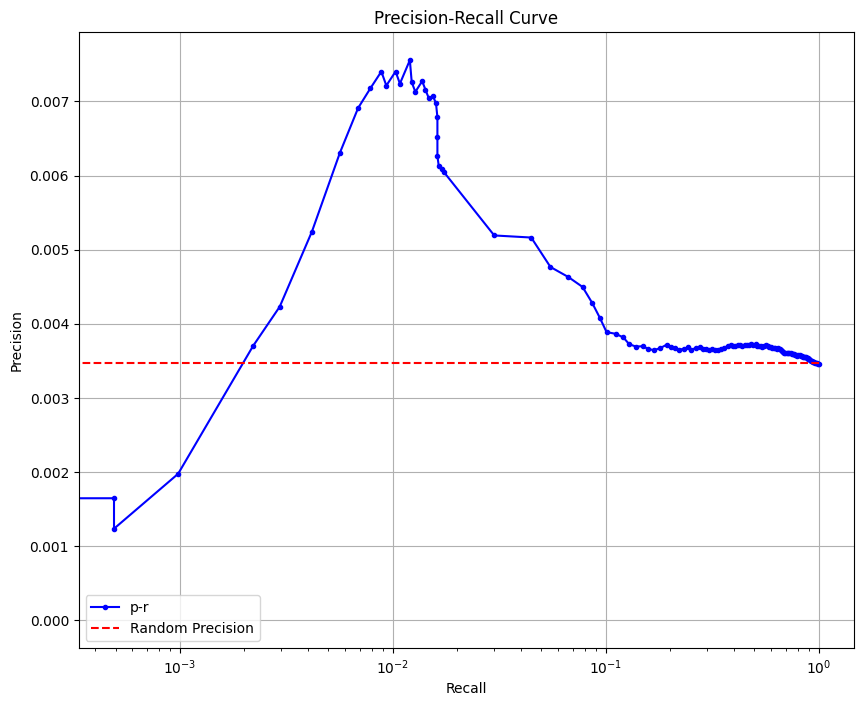

{'naive B cell_scprint_full': {'TF_enr': False,
  'significant_enriched_TFtargets': 6.666666666666667,
  'precision': 0.0034602606173663214,
  'recall': 1.0,
  'rand_precision': 0.003463455687188451,
  'auprc': 0.0037769645332199407,
  'ap': 0.003783484593053828,
  'epr': 2.00204937688296}}

In [20]:
# gene network inference without
metrics = {}
clf_omni = None
shapes = []
for celltype in ['naive B cell']: #['endothelial cell']: #['oligodendrocyte precursor cell']:
    grn_inferer = GNInfer(
                        how="most var across",
                        preprocess="softmax",
                        head_agg='mean',
                        filtration="none",
                        forward_mode="none",
                        num_genes=3_000,
                        max_cells=1000,
                        doplot=False,
                        batch_size=10,
                        cell_type_col="cell_type",
                        layer=list(range(model.nlayers))[:]
                        )
    grn = grn_inferer(model, adata, cell_type=celltype)
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    metrics[celltype+'_scprint_full'] = BenGRN(grn).scprint_benchmark()
    #grn.write_h5ad(f'../data/temp/grn_{celltype}_scprint_f.h5ad')
metrics

In [12]:
from bengrn import get_GT_db

res = get_GT_db(name="omnipath", organism="human")

In [45]:
grn.varp['GRN'] = grn.varp['GRN'].T

In [12]:
adata

AnnData object with n_obs × n_vars = 7427 × 70704
    obs: 'perturbation', 'is_control', 'perturbation_type', 'n_genes', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'cell_type'
    var: 'n_cells', 'n_features_theta_0.0', 'n_features_theta_0.5', 'n_features_theta_1.0', 'uid', 'symbol', 'biotype', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [12]:
from grnndata.utils import TF

In [25]:
grn.varp['GRN'][~grn.var.index.isin(TF),:] = 0

In [29]:
grn.shape[1]

(1000, 3000)

In [46]:
adata.var = adata.var.set_index("symbol", drop=False)
unique_indices = ~adata.var.symbol.duplicated()
# Subset adata to only those indices, then filter for genes in grn
adata = adata[:, unique_indices]
grn = grn[:, adata.var.index]
adata = adata[:, adata.var.symbol.isin(grn.var.index)]

In [47]:
grn.varp['GRN'].sum(0).min(), grn.varp['GRN'].sum(0).max()

(0.011766914, 45.210464)

In [38]:
from grnndata import from_anndata

In [ ]:
grn = grn[:, adata.var.index]
grn._X = grn.X
grn = from_anndata(grn)

In [95]:
# Get indices of top 20 elements for each row
top_20_indices = np.argsort(-grn.varp['GRN'], axis=1)[:, :40]

# Create mask of same shape as GRN with True only for top 20 indices
mask = np.zeros_like(grn.varp['GRN'], dtype=bool)
for i in range(mask.shape[0]):
    mask[i, top_20_indices[i]] = True

# Zero out all elements except top 20 per row
grn.varp['GRN'] = grn.varp['GRN'] * mask


In [97]:
grn.varp['GRN'] = grn.varp['GRN'] * mask

In [54]:
from grnndata.utils import TF
grn.varp['GRN'][~grn.var.index.isin(TF)] = 0

In [89]:
(grn.varp['GRN']>0).sum()

14400

In [56]:
grn.varp['GRN'] = grn.varp['GRN'].T

In [58]:
grn2 = grn.copy()
grn2.varp['GRN'] = np.random.rand(grn.var.shape[0], grn.var.shape[0])
grn2 = from_anndata(grn2)
grn2.varp['GRN'][~grn2.var.index.isin(TF)] = 0

In [ ]:
# random network:
OP: 0.361113	0.538747	0.686487
NORMAN: 0   0   0
ADAMSON: 0	0	0


In [59]:
run_gene_rnib(
    adata,
    grn2
)

[d3graph] INFO> Reading input files


[d3graph] INFO> Static approach (theta=0.0):
100%|██████████| 1507/1507 [00:00<00:00, 5229.82it/s]
[d3graph] INFO> Static approach (theta=0.5):
100%|██████████| 1507/1507 [00:08<00:00, 187.73it/s]
[d3graph] INFO> Static approach (theta=1.0):
100%|██████████| 1507/1507 [00:27<00:00, 54.05it/s]


r2-theta-0.0  r2-theta-0.5  r2-theta-1.0
0      0.292127      0.489342      0.674662

In [57]:
run_gene_rnib(
    adata,
    grn
)

[d3graph] INFO> Reading input files
[d3graph] INFO> Static approach (theta=0.0):
100%|██████████| 1507/1507 [00:00<00:00, 5177.42it/s]
[d3graph] INFO> Static approach (theta=0.5):
100%|██████████| 1507/1507 [00:08<00:00, 177.08it/s]
[d3graph] INFO> Static approach (theta=1.0):
100%|██████████| 1507/1507 [00:26<00:00, 56.87it/s]


r2-theta-0.0  r2-theta-0.5  r2-theta-1.0
0      0.389487      0.530383      0.688528

In [1]:
# making the datasets

In [ ]:
sources/grn_benchmark/evaluation_data/op_bulk.h5ad

In [1]:
FOLDER = '/home/ml4ig1/task_grn_inference/resources/grn_benchmark/'
adata = sc.read_h5ad(FOLDER+'evaluation_data/op_bulk.h5ad')
adata_train = sc.read_h5ad(FOLDER+'inference_data/op_rna.h5ad')
reg = json.load(open(FOLDER+'prior/regulators_consensus_op.json'))

NameError: name 'sc' is not defined

In [83]:
adata.obs['train'] = False
adata_train.obs['train'] = True

In [84]:
adata = sc.concat([adata, adata_train], axis=0)

In [85]:
n_features_theta_min = np.asarray(
    [reg[gene_name]["0"] for gene_name in adata.var_names], dtype=int
)
n_features_theta_median = np.asarray(
    [reg[gene_name]["0.5"] for gene_name in adata.var_names], dtype=int
)
n_features_theta_max = np.asarray(
    [reg[gene_name]["1"] for gene_name in adata.var_names], dtype=int
)


In [86]:
adata.var["n_features_theta_"+str(0.0)] = n_features_theta_min
adata.var["n_features_theta_"+str(0.5)] = n_features_theta_median
adata.var["n_features_theta_"+str(1.0)] = n_features_theta_max


In [87]:
adata.write_h5ad('../../benGRN/data/op_rna.h5ad')

In [40]:
ls ../../benGRN/data/

10xBrain_homo_scenicplus_genebased_scope.loom
10xPBMC_homo_scenicplus_genebased_scope.loom
adamson_sc.h5ad
BH-corrected.csv.gz
ess_perturb_sc.h5ad
GroundTruth/
hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl
norman_sc.h5ad
omnipath.parquet
op_bulk.h5ad
output.tar.gz
tfchip_data.json


In [41]:
adata = sc.read_h5ad('../../benGRN/data/op_bulk.h5ad')

In [ ]:
grn.grn

symbol       STPG1   CYP51A1     RAD52     CFLAR  ARHGAP33  SLC25A13  \
symbol                                                                 
STPG1     0.000025  0.000074  0.000113  0.000014  0.000013  0.000019   
CYP51A1   0.000041  0.000092  0.000074  0.000163  0.000100  0.000033   
RAD52     0.000021  0.000086  0.000071  0.000012  0.000010  0.000011   
CFLAR     0.000181  0.000177  0.000119  0.000599  0.003131  0.000063   
ARHGAP33  0.000022  0.000019  0.000066  0.000020  0.000013  0.000026   
...            ...       ...       ...       ...       ...       ...   
PIK3R6    0.000055  0.000189  0.000017  0.000182  0.000043  0.000019   
PAGR1     0.000034  0.000139  0.000012  0.000360  0.000043  0.000009   
TUBA3FP   0.000060  0.000123  0.000073  0.000086  0.000115  0.000034   
ACTL10    0.000024  0.000211  0.000007  0.000143  0.000020  0.000014   
PANO1     0.000115  0.000132  0.000040  0.000172  0.000051  0.000040   

symbol       CDC27      LIG3     ACSM3   TSPOAP1     ABCB4       ZFX  \
symbol                                                                 
STPG1     0.000049  0.000424  0.000039  0.000015  0.000008  0.000223   
CYP51A1   0.000066  0.000284  0.000017  0.000024  0.000032  0.000259   
RAD52     0.000052  0.000561  0.000040  0.000013  0.000009  0.000208   
CFLAR     0.000106  0.000090  0.000051  0.000051  0.000048  0.000405   
ARHGAP33  0.000064  0.000140  0.000021  0.000007  0.000024  0.000045   
...            ...       ...       ...       ...       ...       ...   
PIK3R6    0.000044  0.000029  0.000031  0.000012  0.000032  0.000750   
PAGR1     0.000010  0.000029  0.000136  0.000005  0.000011  0.001630   
TUBA3FP   0.000069  0.000386  0.000025  0.000027  0.000050  0.000731   
ACTL10    0.000047  0.000077  0.000071  0.000006  0.000012  0.001861   
PANO1     0.000051  0.000069  0.000046  0.000055  0.000067  0.000264   

symbol       AP2B1  TNFRSF12A   ADIPOR2     CDKL3    BAIAP3      PIGQ  \
symbol                                                                  
STPG1     0.000036   0.000374  0.000011  0.000009  0.000085  0.000125   
CYP51A1   0.000040   0.000459  0.000022  0.000013  0.000195  0.000069   
RAD52     0.000037   0.000379  0.000005  0.000007  0.000098  0.000102   
CFLAR     0.000054   0.001046  0.000025  0.000683  0.000386  0.000072   
ARHGAP33  0.000076   0.000091  0.000015  0.000016  0.000172  0.000086   
...            ...        ...       ...       ...       ...       ...   
PIK3R6    0.000075   0.000024  0.000024  0.000014  0.000204  0.000018   
PAGR1     0.000023   0.000033  0.000004  0.000007  0.000120  0.000021   
TUBA3FP   0.000124   0.000026  0.000024  0.000036  0.000248  0.000063   
ACTL10    0.000058   0.000027  0.000007  0.000007  0.000073  0.000013   
PANO1     0.000040   0.000023  0.000019  0.000046  0.000133  0.000057   

symbol      CRAMP1     PSMB1     SYPL1      AASS      MPND   RHOBTB2  \
symbol                                                                 
STPG1     0.000440  0.000144  0.000193  0.000017  0.000049  0.000015   
CYP51A1   0.000258  0.000245  0.000019  0.000015  0.000084  0.000034   
RAD52     0.000551  0.000243  0.000194  0.000024  0.000042  0.000011   
CFLAR     0.000251  0.000127  0.000065  0.000694  0.000223  0.000053   
ARHGAP33  0.000104  0.000252  0.000054  0.000077  0.000046  0.000015   
...            ...       ...       ...       ...       ...       ...   
PIK3R6    0.000409  0.000379  0.000024  0.000021  0.000034  0.000021   
PAGR1     0.000145  0.000061  0.000018  0.000023  0.000048  0.000011   
TUBA3FP   0.000369  0.000243  0.000031  0.000108  0.000032  0.000040   
ACTL10    0.000128  0.000175  0.000088  0.000021  0.000042  0.000008   
PANO1     0.000603  0.000390  0.000017  0.000038  0.000036  0.000045   

symbol    TRAF3IP3     BAZ1B      ETV7  STARD3NL     NISCH    LRRC23  \
symbol                                                                 
STPG1     0.006015  0.000172  0.000007  0.000008  0.000023  0.000007   
CYP51A1   0.005376  0.0

In [11]:
from bengrn.GeneRNIB_reg2 import run_gene_rnib


In [47]:
adata.var.index

Index(['SPRYD3', 'MCM2', 'C2CD2', 'CERK', 'AMZ2', 'CAPS', 'ZNF566', 'METTL6',
       'DPP9', 'AL353763.2',
       ...
       'SH3D21', 'RPS4Y1', 'ADPRH', 'AHRR', 'PXMP2', 'AC007098.1', 'ALDH16A1',
       'RRM2B', 'CCT4', 'AC006547.1'],
      dtype='object', name='index', length=2000)

In [46]:
grn.var.index

Index(['STPG1', 'CYP51A1', 'RAD52', 'CFLAR', 'ARHGAP33', 'SLC25A13', 'CDC27',
       'LIG3', 'ACSM3', 'TSPOAP1',
       ...
       'MLLT6', 'NUDT18', 'CCL18', 'TUBGCP5', 'DUSP14', 'PIK3R6', 'PAGR1',
       'TUBA3FP', 'ACTL10', 'PANO1'],
      dtype='object', name='symbol', length=1507)

In [ ]:
grn.

In [32]:
grn.shape, adata.shape

((2000, 1507), (2000, 2000))

In [38]:
run_gene_rnib(
    adata,
    grn
)


ValueError: Lengths must match to compare

In [ ]:
# gene network inference

In [ ]:
# embedding and cell type prediction with

In [ ]:
# embedding and cell type prediction without